# **Physics-based loss and machine learing approach in application to fluids flow modelling: 2D flow domains**

The program recieves an image of the flow domain and the flow rate value, then calculate velocity distribution. The main idea is power loss minimization. The main unknown function is the stream function $\psi = \psi(x_1, x_2)$ that determines the velocity field $\textbf{V} = [[v_1, v_2]]$, where $v_1 = \frac{\partial \psi}{\partial x_2}$, $v_2 = - \frac{\partial \psi}{\partial x_1}$.



# Import libraries

In [1]:
# Pytorch modules
import torch
from torch import nn

# Paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict
#from scipy import integrate

# Status bar
from tqdm.notebook import tqdm

# Work with files
import json
import os

# Constants

In [2]:
EPOCHS = 20000
SIZE = 224 # image size
FIGSIZE = 5 # figure size
S2 = int(SIZE*0.4)
S3 = SIZE - S2
UP_COLOR =  torch.tensor((0, 0, 0)) # upper wall 
LOW_COLOR =  torch.tensor((0, 0, 1)) # upper wall
CENTER_COLOR = torch.tensor((1, 1, 1)) # flow domain
WORK_DIR = '/root/Physics_based_loss'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "unet"
EARLY_STOP_PATIENCE = 10
DECAY = 0

HYPS = []

hyps = {"learning_rate": [1e-3],
        "scheduler": ["None", "step", "cycle"],
        "scheduler_factor": [0.1],
        "scheduler_patience": [5],
        "use_bn": [True, False]} # Use or not batchnorm
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})

# Geometry of the flow domain and the dynamic properties of fluid
The fluid is Newtonian.
The domain of size *'L x L'*  with flow channel is represented as an image of size *'imgSize x imgSize'*. S1 is the upper wall with black label [0 0 0]. S2 and S4 are outlet and inlet surfaces, respectivelly. S3 is the lower wall with blue label [0 0 255]. 

In [3]:
# L x L flow domain
L = 0.1 

# Normalized coordinates
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)
DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
LIM1 = [0, L]
LIM2 = [0, L]

# Flow rate through the inlet (outlet) boundary, m^3/s
Q = 0.1 

# Koefficient of dynamic viscosity (viscosity), Pa*s
MU = 1e-3 

# Additional functions

Numerical derivative

In [4]:
def num_diff(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
    # x1 derivative:
    df_dx1[:, 1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx1)
    df_dx1[:, 0] = (-f[:, 2] + 4 * f[:,1] - 3 * f[:,0]) / (2 * dx1)
    df_dx1[:, n2-1] = (3 * f[:,n2-1] - 4 * f[:,n2-2] + f[:,n2-3]) / dx1
    # x2 derivative:
    df_dx2[1:n1-1, :] = (f[2:, :] - f[:-2,:]) / (2 * dx2)
    df_dx2[0, :] = (- f[2,:] + 4 * f[1,:] - 3 * f[0, :]) / (2 * dx2)
    df_dx2[n1-1, :] = (3 * f[n1 - 1, :] - 4 * f[n1 - 2, :] + f[n1 - 3, :]) / (2 * dx2)

    return df_dx1, df_dx2

Numerical integrals: single and double can be implemented by torch.trapezoid function https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid


# Major functions

Distributions: the velocity components [[$v_1$, $v_2$]], the strain rate tensor components [[$\xi_{ij}$]], $\xi_{ij}=\xi_{ji}$ . And the shear rate intensity Η. 

In [5]:
def velocityDistr(psi,dx1n,dx2n,lim1,lim2):
    '''Velocity distribution [[v1, v2]] in the flow domain
    '''
    n = psi.shape
    v1 = 0
    v2 = 0
    dpsidx1 = 0
    dpsidx2 = 0
    dpsidx1, dpsidx2 = num_diff(psi, dx1n, dx2n)
    v1 = dpsidx2 / lim2[1]
    v2 = - dpsidx1 / lim1[1]
    
    return v1,v2

In [6]:
def TksiDistr(v1,v2,dx1n,dx2n,lim1,lim2):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
    n = v1.shape
    xi11 = 0
    xi12 = 0
    xi22 = 0
    dv1dx1 = 0
    dv1dx2 =0
    dv2dx1 = 0
    dv2dx2 = 0
  
    dv1dx1, dv1dx2 = num_diff(v1, dx1n, dx2n)
    dv2dx1, dv2dx2 = num_diff(v2, dx1n, dx2n)
  
    xi11 = dv1dx1 / lim1[1]
    xi12 = 0.5 * (dv1dx2 / lim2[1] + dv2dx1 / lim1[1])
    xi22 = dv2dx2 / lim2[1]
    EtaEta = (2 * (xi11 * xi11 + 2* xi12 * xi12 + xi22 * xi22))
  
    return xi11, xi12, xi22, EtaEta

# Callbacks

In [7]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Functions of model

In [8]:
def train(model, inp, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Inpu image.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    for e in range(epochs):
        model.train()

        running_loss = 0

        stop = False
        
        steps = 0
        
        optimizer.zero_grad()
        
        out = model.forward(inp)
            
        loss = criterion(out)

        loss.backward()
                
        optimizer.step()
            
        with torch.no_grad():
            running_loss = loss.item()
        
        if (e + 1) % print_every == 0:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            model.train()
            
        
        history['Train loss'].append(running_loss)
        
        if lr_scheduler:
            if "OneCycleLR" in str(lr_scheduler):
                lr_scheduler.step()
            else:
                lr_scheduler.step(running_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            bar.update()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Domain mask

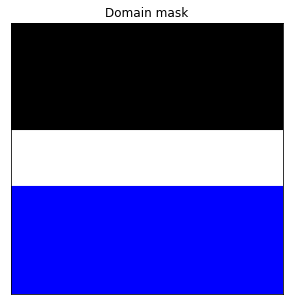

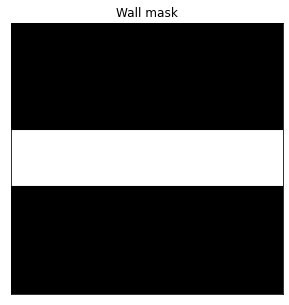

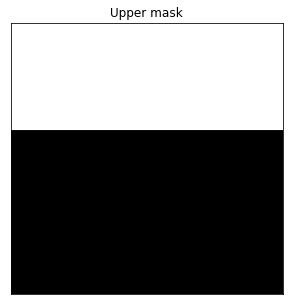

In [9]:
domain_mask = torch.ones((SIZE, SIZE, 3))
domain_mask[:S2, :, :] = 0
domain_mask[S3:, :, :2] = 0

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(domain_mask)
plt.xticks([])
plt.yticks([])
plt.title("Domain mask")
plt.show()

wall_mask = (domain_mask == CENTER_COLOR).float().sum(axis=2)
wall_mask[wall_mask < 3] = 0
wall_mask[wall_mask == 3] = 1

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(wall_mask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Wall mask")
plt.show()

upper_mask = (domain_mask == UP_COLOR).float().sum(axis=2)
upper_mask[upper_mask < 3] = 0
upper_mask[upper_mask == 3] = 1

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(upper_mask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Upper mask")
plt.show()

# Kinematic properties
The velocity is equal to zero on all the surfaces. The flow rate is known.

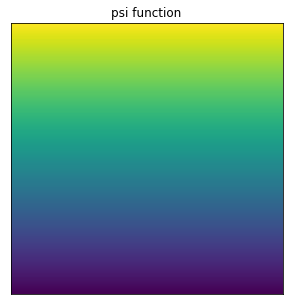

In [10]:
psi0 = (torch.linspace(Q * 4, 0,SIZE, dtype=torch.float32) * torch.ones(SIZE,SIZE)).T - 1.5 * Q

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(psi0)
plt.xticks([])
plt.yticks([])
plt.title('psi function')
plt.show()

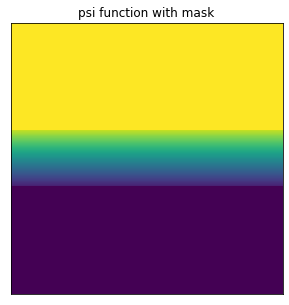

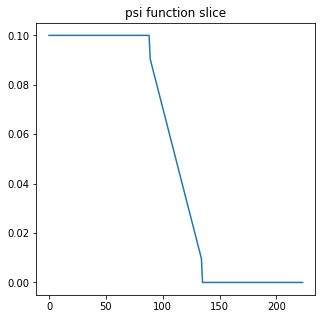

In [11]:
psi0_masked = (psi0 * wall_mask) + (upper_mask * Q)

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(psi0_masked)
plt.title('psi function with mask')
plt.xticks([])
plt.yticks([])
plt.show()

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.plot(psi0_masked[:,200])
plt.title('psi function slice')
plt.show()

# Velocity distribution

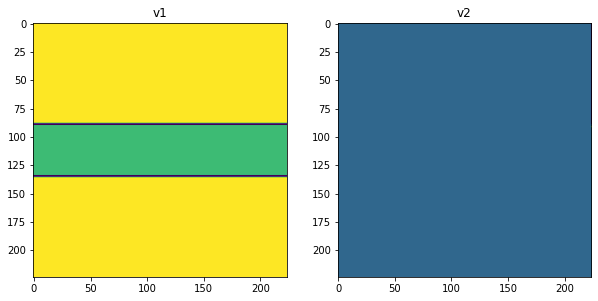

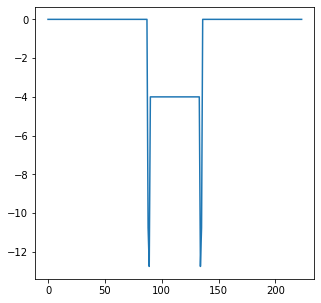

In [12]:
v1, v2 = velocityDistr(psi0_masked, DX1N, DX2N, LIM1, LIM2)
#v1Masked = (v1*velocityMask) + v1Mask
#v2Masked = (v2*velocityMask)
#v2Masked = torch.zeros(imgSize,imgSize)
fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE))
plt.subplot(1,2,1)
plt.imshow(v1.cpu())
plt.title('v1')
plt.subplot(1,2,2)
plt.imshow(v2.cpu())
plt.title('v2')
plt.show()

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.plot(v1[:,1].cpu())
plt.show()

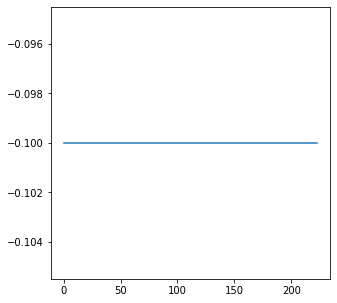

In [13]:
# Check the flow rate
Qch = torch.trapezoid(v1.t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.plot(Qch.cpu())
plt.show()

In [14]:
# velocityMask = torch.ones(imgSize,imgSize)
# velocityMask[:,0:3] = 0
# velocityMask[:,-3:] = 0
# fig = plt.figure(figsize=(figSize, figSize))
# plt.plot(velocityMask[1,:])
# velocityMask[1,:]

In [15]:
# h=(126-92)*L/126
# vm = (velocityMask*-1 + 1)*Q/L
# Qcalc = torch.trapezoid(vm.t())*dx2n*L
# plt.plot(Qcalc)

In [16]:
# v1Mask = vm*wallsMask
# fig = plt.figure(figsize=(figSize*4, figSize*2))
# plt.imshow(v1Mask )
# plt.title('v1 mask')
# v1Mask[300,:]

## Check assimptotic solution: flow between parallel plates
Newtonian fluid flows between parallel plates LxL

h = 0.02053571428571429 L= 0.1 (p1-p0) = -13.856444480973119 
v1max = tensor(7.3042) Ext = -1.385644448097312 Int = tensor(1.3857, device='cuda:0')


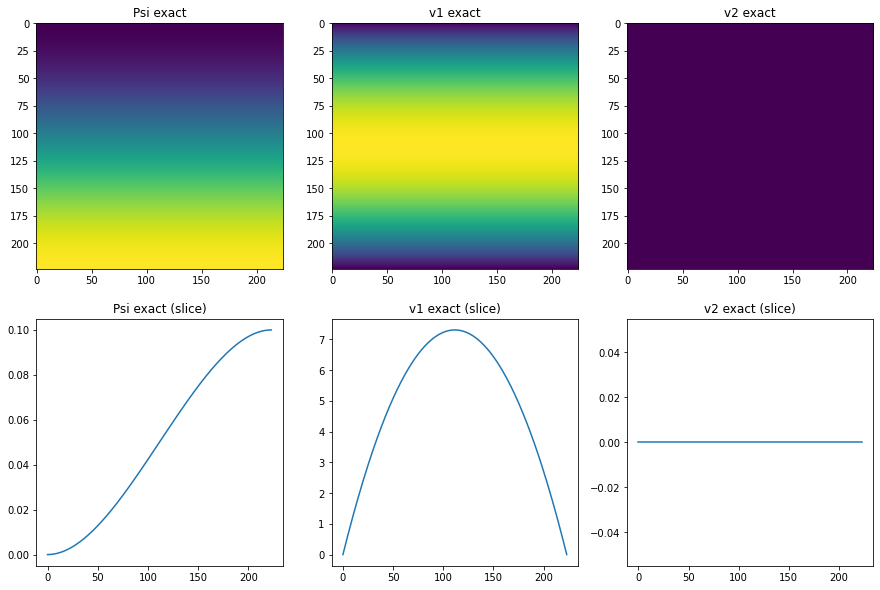

In [17]:
#Exact solution
sp = int(SIZE/2)#slice position
h=(SIZE-2*S2)*L/SIZE#(126-92)*L/126 # h is thickness of the channel, L is it's length
# v1ex = pressureDrop / (2 * MU * L) * X2N*(X2N - 1) * h ** 2
# v1exmax = pressureDrop / (2 * MU * L) * X2N[int(SIZE/2)]*(X2N[int(SIZE/2)] - 1) * h ** 2 # in the middle of the flow
# psiex = (pressureDrop / (2 * MU * L) * (X2N ** 2)*((X2N/3) - (1/2)) * (h ** 3) + Q
#        + pressureDrop / (12 * MU * L) * (h ** 3))
C0 = -12*MU*Q/(h**3)
C1 = 6*Q/(h**2)
psiex = C0*(X2N**3)*h**3/(6*MU) + C1*(X2N**2/2)*h**2
v1ex = C0*(X2N**2)*h**2/(2*MU) + C1*(X2N)*h
v1exmax = v1ex[int(SIZE/2)] 

pressureDrop = C0*L
Extex = pressureDrop * Q

# From 1D to 2D
psiex = psiex * torch.ones(SIZE, SIZE)
psiex = psiex.t()

v1ex = v1ex * torch.ones(SIZE, SIZE)
v1ex = v1ex.t()

v2ex = torch.zeros(SIZE, SIZE)

#Calculate Internal power to check numerical integration
lim1 = [0, L]
lim2 = [0, h]

xi11, xi12, xi22, EtaEta = TksiDistr(v1ex, v2ex, DX1N, DX2N, lim1, lim2)
#xi11,xi12,xi22,EtaEta = TksiDistr(v1Masked,v2Masked,dx1n,dx2n,lim1,lim2)

int1EtaEta = torch.trapz(EtaEta)
#int1EtaEta = scipy.integrate.fixed_quad(EtaEta.cpu(),0,1)
int2EtaEta = torch.trapz(int1EtaEta)
#int1EtaEta = scipy.integrate.fixed_quad(int1EtaEta.cpu(),0,1)

s = DX1N * DX2N * lim1[1] * lim2[1]
Intex = MU*s*int2EtaEta #doublelIntegral
# EtaEta = np.array(EtaEta)
# X1N = np.array(X1N)
# X2N = np.array(X2N)
#Intex = 0.5*MU*s*scipy.integrate.dblquad(EtaEta.cpu(),0,1,X1N.cpu(),X2N.cpu()) #doublelIntegra



print('h =', h, 'L=', L, '(p1-p0) =', pressureDrop,
      '\nv1max =', v1exmax, 'Ext =', Extex, 'Int =', Intex)


fig = plt.figure(figsize=(FIGSIZE*3, FIGSIZE*2))
plt.subplot(2,3,1)
plt.imshow(psiex)
plt.title('Psi exact')

plt.subplot(2,3,2)
plt.imshow(v1ex)
plt.title('v1 exact')

plt.subplot(2,3,3)
plt.imshow(v2ex)
plt.title('v2 exact')

plt.subplot(2,3,4)
plt.plot(psiex[:,sp])
plt.title('Psi exact (slice)')

plt.subplot(2,3,5)
plt.plot(v1ex[:,sp])
plt.title('v1 exact (slice)')

plt.subplot(2,3,6)
plt.plot(v2ex[:,sp])
plt.title('v2 exact (slice)')

plt.show()

In [18]:
X2N.shape, int(SIZE/2),Intex/Extex

(torch.Size([224]), 112, tensor(-1.0000, device='cuda:0'))

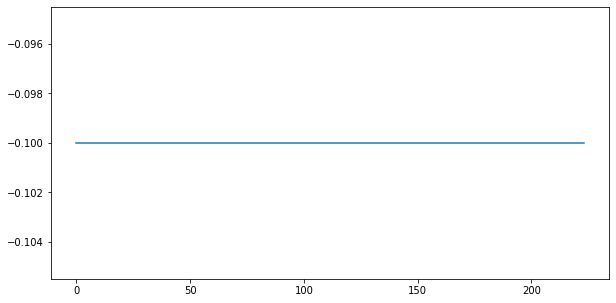

In [19]:
Qcalc = torch.trapezoid(v1.t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE))
plt.plot(Qcalc.cpu())
plt.show()

## Create model
Unet architecture [2] is used

In [20]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.ReLU(inplace=True))][0 if use_bn else 1:],
                ]
            )
        )
    
def power_loss(psi):
    psi_masked = (psi[0,0,:,:] * wall_mask) + (upper_mask * Q)
    v1,v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)

    #v1Masked = (v1*velocityMask) + v1Mask
    #v2Masked = (v2*velocityMask)
    #v2Masked = torch.zeros(imgSize,imgSize)

    xi11, xi12, xi22, EtaEta = TksiDistr(v1, v2, DX1N, DX2N, LIM1, LIM2)
    #xi11,xi12,xi22,EtaEta = TksiDistr(v1Masked,v2Masked,dx1n,dx2n,lim1,lim2)
    
    int1EtaEta = torch.trapezoid(EtaEta)
    int2EtaEta = torch.trapezoid(int1EtaEta)
    out = 0.5*MU*s*int2EtaEta #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    return out #0.5 * MU * s * EtaEta.mean()

# Training

hyperparams: 
 learning_rate 0.001, scheduler None, scheduler_factor 0.1, scheduler_patience 5, use_bn True



Best Train loss 40.2067
hyperparams: 
 learning_rate 0.001, scheduler None, scheduler_factor 0.1, scheduler_patience 5, use_bn False



Best Train loss 1386.1960
hyperparams: 
 learning_rate 0.001, scheduler step, scheduler_factor 0.1, scheduler_patience 5, use_bn True



Best Train loss 11.5115
hyperparams: 
 learning_rate 0.001, scheduler step, scheduler_factor 0.1, scheduler_patience 5, use_bn False



Best Train loss 1386.1960
hyperparams: 
 learning_rate 0.001, scheduler cycle, scheduler_factor 0.1, scheduler_patience 5, use_bn True



Best Train loss 3.2631
hyperparams: 
 learning_rate 0.001, scheduler cycle, scheduler_factor 0.1, scheduler_patience 5, use_bn False



Best Train loss 1386.1960
Best Train loss: 3.2631, best hyperparams: learning_rate: 0.001, scheduler: cycle, scheduler_factor: 0.1, scheduler_patience: 5, use_bn: True


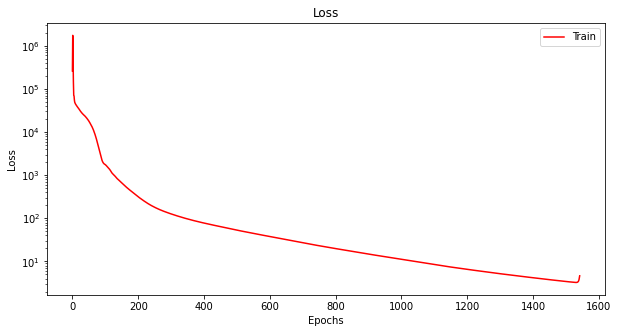

Final loss: 163826.464


In [21]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

x = torch.ones((1, 1, SIZE, SIZE)) * psi0_masked
s = DX1N * DX2N * LIM1[1] * LIM2[1]

# Перемещение на GPU
x = x.to(DEVICE)
wall_mask = wall_mask.to(DEVICE)
upper_mask = upper_mask.to(DEVICE)
DX1N = DX2N.to(DEVICE)
DX2N = DX2N.to(DEVICE)
s = s.to(DEVICE)

run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]

    model = UNet(in_channels=1, out_channels=1, init_features=32, use_bn=hyp["use_bn"])

    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)

    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None

    history = train(model, x, optimizer, power_loss,
                    epochs=EPOCHS, print_every=10,
                    callbacks=callbacks, lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_val_metric, best_hyp))

model = UNet(in_channels=1, out_channels=1, init_features=32, use_bn=best_hyperparams["use_bn"])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

psi = model.forward(x)

plot_train_history(best_run['history'])

print(f'Final loss: {power_loss(psi).cpu().item() * SIZE ** 2:.3f}')

# Results

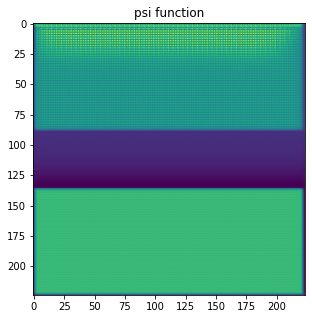

In [22]:
fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(psi[0, 0, :, :].clone().detach().to('cpu'))
plt.title('psi function')
plt.show()

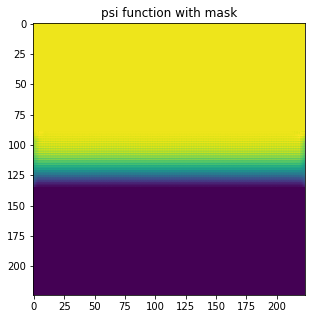

In [23]:
psicheck = psi[0, 0, :, :].clone().detach()
psi_masked = (psicheck * wall_mask) + (upper_mask * Q)

fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.imshow(psi_masked.to('cpu'))
plt.title('psi function with mask')
plt.show()

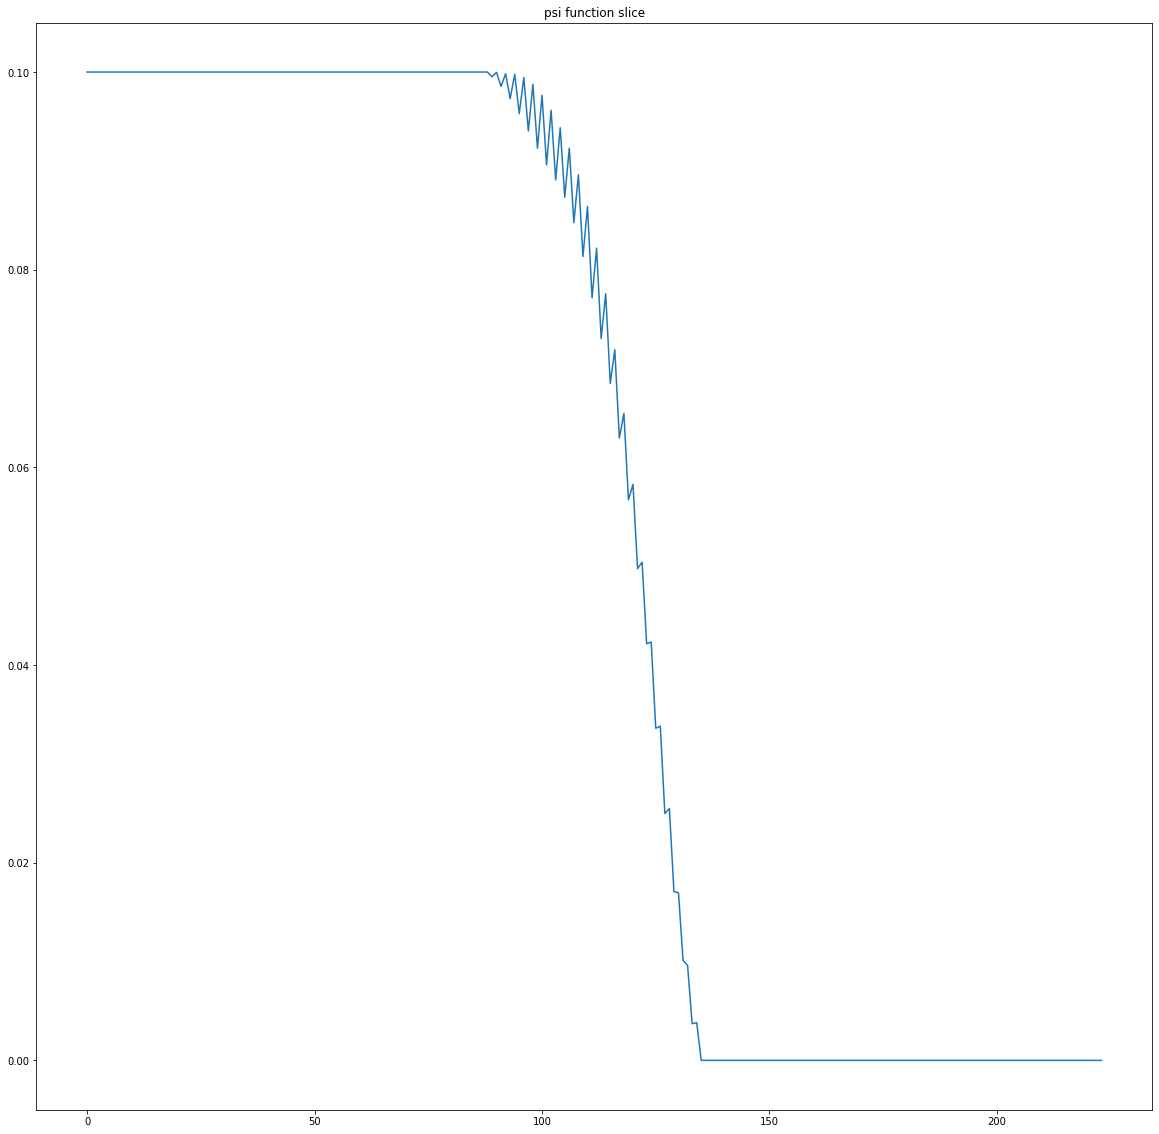

In [24]:
fig = plt.figure(figsize=(FIGSIZE*4, FIGSIZE*4))
plt.plot(psi_masked[:, int(SIZE/2)].to('cpu'))
plt.title('psi function slice')
plt.show()

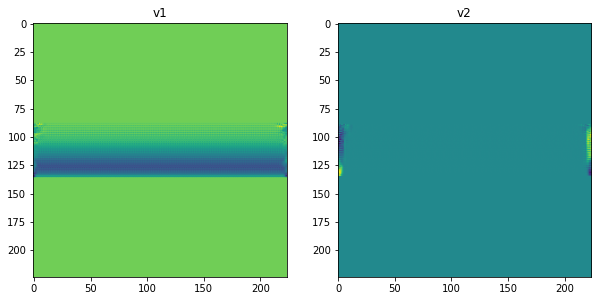

In [25]:
v1, v2 = velocityDistr(psi_masked, DX1N, DX2N, LIM1, LIM2)

fig = plt.figure(figsize=(FIGSIZE * 2, FIGSIZE))
plt.subplot(1,2,1)
plt.imshow(v1.to('cpu'))
plt.title('v1')
plt.subplot(1,2,2)
plt.imshow(v2.to('cpu'))
plt.title('v2')
plt.show()

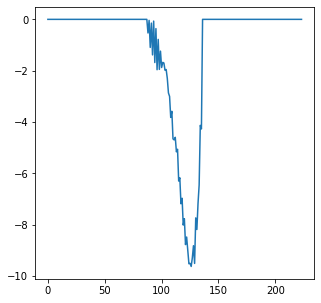

tensor(-9.6237, device='cuda:0') tensor(0., device='cuda:0')


In [26]:
fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
plt.plot(v1[:,int(SIZE/2)].to('cpu'))
plt.show()
print(v1[:,int(SIZE/2)].min(), v1[:,int(SIZE/2)].max())

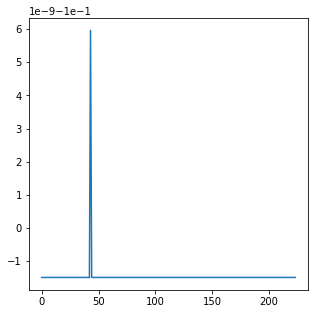

In [27]:
fig = plt.figure(figsize=(FIGSIZE, FIGSIZE))
Qcalc = torch.trapezoid(v1.t()) * DX2N * L
plt.plot(Qcalc.cpu())
plt.show()

In [28]:
print(Qcalc.mean().cpu().item())

-0.10000000894069672


# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch